In [1]:
# !pip install shap

In [2]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [3]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [4]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [5]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [6]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [7]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [10]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [11]:
class Embedding(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.position_embeddings = nn.Embedding(config.sequence_length, config.input_feature)
    self.norm_layer = nn.LayerNorm(config.input_feature , eps=1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_tensor):
      device = input_tensor.device  # input_tensor의 디바이스를 가져옵니다.
      input_pos = torch.arange(input_tensor.size(1), dtype=torch.long, device=device)  # 디바이스를 지정하여 input_pos를 생성합니다.
      pos_emb = self.position_embeddings(input_pos).unsqueeze(0)
      final_emb = input_tensor + pos_emb
      final_emb = self.norm_layer(final_emb)
      final_emb = self.dropout(final_emb)
      return final_emb

In [12]:
from math import sqrt
def scaled_dot_product(query,key,value):
  dim_k = query.size(-1)
  similiarity = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
  similiarity = F.softmax(similiarity, dim = -1) #여기 조심하자
  return torch.bmm(similiarity,value)

In [13]:
class Attention_head(nn.Module):
  def __init__(self, emb_dim, head_dim):
    super().__init__()
    self.query = nn.Linear(emb_dim, head_dim)
    self.key = nn.Linear(emb_dim, head_dim)
    self.value = nn.Linear(emb_dim, head_dim)

  def forward(self, final_emb):
    q = self.query(final_emb)
    k = self.key(final_emb)
    v = self.value(final_emb)
    return scaled_dot_product(q, k, v)

In [14]:
class Multihead_attention(nn.Module):
  def __init__(self,config):
    super().__init__()
    input_feature = config.input_feature
    self.attention_heads = nn.ModuleList([Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,3)])
    self.dense_layer = nn.Linear(input_feature, input_feature)

  def forward(self, final_emb):
    x = torch.cat([h(final_emb) for h in self.attention_heads],dim = -1)
    x = self.dense_layer(x)
    return x

In [15]:
class Feedforward(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.layer1 = nn.Linear(config.input_feature, config.feed_foward_dim)
    self.layer2 = nn.Linear(config.feed_foward_dim, config.input_feature)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.layer1(x)
    x = self.gelu(x)
    x = self.layer2(x)
    x = self.dropout(x)
    return x

In [16]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.Norm1 = nn.LayerNorm(config.input_feature)
    self.Norm2 = nn.LayerNorm(config.input_feature)
    self.attention = Multihead_attention(config)
    self.feedforward = Feedforward(config)

  def forward(self,x):
    norm = self.Norm1(x)
    x = x + self.attention(norm)
    x = x + self.feedforward(self.Norm2(x))
    return x

In [17]:
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        dim_k = q.size(-1)

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (dim_k ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        weighted_average = torch.matmul(attention_weights, x)

        return weighted_average.mean(dim=1)

In [18]:
class TransformerEncoder(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.embedding = Embedding(config)
    self.layers = nn.ModuleList([TransformerEncoderLayer(config) for i in range(config.num_layers)])
    self.attention = AttentionMechanism(config.input_feature)
    self.classifier = nn.Linear(config.input_feature, 2)

  def forward(self,x):
    x = self.embedding(x)
    for layer in self.layers:
      x = layer(x)
    x = self.attention(x)
    x = self.classifier(x)
    return x

# trainer 구현

In [19]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [20]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 6000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_feature = 19     # input feature 이거 바꾸면 모델 안 돌아감
  feed_foward_dim = 100  # feed forward dimension
  num_layers = 12        # encoder block 개수

config = Config()

In [21]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [22]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [23]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


In [24]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 6000
failure(1)의 개수 : 1569


In [25]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [26]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [27]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [28]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 4541
Total number of data samples in valid_loader: 1513
Total number of data samples in test_loader: 1514


In [29]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [30]:
# model, optimizer, loss_function 구현하고 결합시키기
model = TransformerEncoder(config)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [31]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/6000_Transformer') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 6/6 [00:00<00:00, 45.26it/s]


Model saved
TRAIN LOSS = 0.002272821121136015, TRAIN ACC = 0.7476326800264259, 
VALID LOSS = 0.0018769049991146272, VALID ACC = 0.7984137475214805, 
epoch 2


100%|██████████| 6/6 [00:00<00:00, 75.49it/s]


Model saved
TRAIN LOSS = 0.0018955545655380548, TRAIN ACC = 0.7938780004404317, 
VALID LOSS = 0.0017617748261128368, VALID ACC = 0.8162590879048248, 
epoch 3


100%|██████████| 6/6 [00:00<00:00, 73.04it/s]


TRAIN LOSS = 0.0018033160102233518, TRAIN ACC = 0.8007046905967848, 
VALID LOSS = 0.0017768147365194397, VALID ACC = 0.7799074686054197, 
epoch 4


100%|██████████| 6/6 [00:00<00:00, 78.45it/s]


TRAIN LOSS = 0.0017323876708332491, TRAIN ACC = 0.8081920281876239, 
VALID LOSS = 0.0017263568046466452, VALID ACC = 0.797752808988764, 
epoch 5


100%|██████████| 6/6 [00:00<00:00, 80.59it/s]


TRAIN LOSS = 0.0016898737161649374, TRAIN ACC = 0.8123761286060339, 
VALID LOSS = 0.0016895804827526872, VALID ACC = 0.7858559153998678, 
epoch 6


100%|██████████| 6/6 [00:00<00:00, 75.65it/s]


TRAIN LOSS = 0.0016493179335570025, TRAIN ACC = 0.8143580709094913, 
VALID LOSS = 0.001709932140065437, VALID ACC = 0.7812293456708526, 
epoch 7


100%|██████████| 6/6 [00:00<00:00, 79.38it/s]


TRAIN LOSS = 0.0016115397129571273, TRAIN ACC = 0.8141378550979961, 
VALID LOSS = 0.0016426161000528481, VALID ACC = 0.8030403172504957, 
epoch 8


100%|██████████| 6/6 [00:00<00:00, 80.79it/s]


TRAIN LOSS = 0.0016303149397954414, TRAIN ACC = 0.809953754679586, 
VALID LOSS = 0.0016001235036288992, VALID ACC = 0.8083278255122274, 
epoch 9


100%|██████████| 6/6 [00:00<00:00, 76.33it/s]


TRAIN LOSS = 0.0016199548623551884, TRAIN ACC = 0.8108346179255671, 
VALID LOSS = 0.001615524587454736, VALID ACC = 0.8122934567085262, 
epoch 10


100%|██████████| 6/6 [00:00<00:00, 76.80it/s]


TRAIN LOSS = 0.0015802342929495665, TRAIN ACC = 0.8198634661968729, 
VALID LOSS = 0.0015542381501560249, VALID ACC = 0.8129543952412426, 
epoch 11


100%|██████████| 6/6 [00:00<00:00, 80.15it/s]


Model saved
TRAIN LOSS = 0.001569554980854924, TRAIN ACC = 0.8189826029508919, 
VALID LOSS = 0.0015603995882590245, VALID ACC = 0.8195637805684072, 
epoch 12


100%|██████████| 6/6 [00:00<00:00, 77.45it/s]


TRAIN LOSS = 0.001557594247652922, TRAIN ACC = 0.8170006606474345, 
VALID LOSS = 0.0015685210067234682, VALID ACC = 0.8142762723066754, 
epoch 13


100%|██████████| 6/6 [00:00<00:00, 79.69it/s]


TRAIN LOSS = 0.001550897781976491, TRAIN ACC = 0.8189826029508919, 
VALID LOSS = 0.0017032391057452538, VALID ACC = 0.813615333773959, 
epoch 14


100%|██████████| 6/6 [00:00<00:00, 78.50it/s]


Model saved
TRAIN LOSS = 0.001578192666510973, TRAIN ACC = 0.8209645452543493, 
VALID LOSS = 0.0015272945264121671, VALID ACC = 0.8202247191011236, 
epoch 15


100%|██████████| 6/6 [00:00<00:00, 78.51it/s]


TRAIN LOSS = 0.00153275585284818, TRAIN ACC = 0.8233869191807972, 
VALID LOSS = 0.0015658294019995347, VALID ACC = 0.8089887640449438, 
epoch 16


100%|██████████| 6/6 [00:00<00:00, 78.52it/s]


TRAIN LOSS = 0.0015520217055871187, TRAIN ACC = 0.8183219555164061, 
VALID LOSS = 0.0015375064999869701, VALID ACC = 0.8189028420356906, 
epoch 17


100%|██████████| 6/6 [00:00<00:00, 79.91it/s]


TRAIN LOSS = 0.0015218474546788258, TRAIN ACC = 0.8229464875578066, 
VALID LOSS = 0.001602308055224674, VALID ACC = 0.8182419035029742, 
epoch 18


100%|██████████| 6/6 [00:00<00:00, 75.54it/s]


Model saved
TRAIN LOSS = 0.0015279766852255568, TRAIN ACC = 0.8218454085003303, 
VALID LOSS = 0.0015395291775011969, VALID ACC = 0.828155981493721, 
epoch 19


100%|██████████| 6/6 [00:00<00:00, 79.56it/s]


TRAIN LOSS = 0.0015303217230639094, TRAIN ACC = 0.8229464875578066, 
VALID LOSS = 0.0014567750420542008, VALID ACC = 0.828155981493721, 
epoch 20


100%|██████████| 6/6 [00:00<00:00, 80.06it/s]


Model saved
TRAIN LOSS = 0.0014889836573858037, TRAIN ACC = 0.8255890772957498, 
VALID LOSS = 0.0014565584286111756, VALID ACC = 0.8288169200264376, 
epoch 21


100%|██████████| 6/6 [00:00<00:00, 74.69it/s]


Model saved
TRAIN LOSS = 0.0014697473181997777, TRAIN ACC = 0.8337370623210747, 
VALID LOSS = 0.0015422351810999919, VALID ACC = 0.8321216126900198, 
epoch 22


100%|██████████| 6/6 [00:00<00:00, 76.86it/s]


Model saved
TRAIN LOSS = 0.0014781871705138192, TRAIN ACC = 0.8242677824267782, 
VALID LOSS = 0.001425990050625344, VALID ACC = 0.845340383344349, 
epoch 23


100%|██████████| 6/6 [00:00<00:00, 79.07it/s]


TRAIN LOSS = 0.0014802956799005416, TRAIN ACC = 0.8264699405417308, 
VALID LOSS = 0.0014520675751521583, VALID ACC = 0.8274950429610046, 
epoch 24


100%|██████████| 6/6 [00:00<00:00, 81.10it/s]


TRAIN LOSS = 0.0014466134245976875, TRAIN ACC = 0.8328561990750936, 
VALID LOSS = 0.00145510227098736, VALID ACC = 0.8360872438863186, 
epoch 25


100%|██████████| 6/6 [00:00<00:00, 78.99it/s]


TRAIN LOSS = 0.001438845978568656, TRAIN ACC = 0.8335168465095794, 
VALID LOSS = 0.0014088708126852234, VALID ACC = 0.8440185062789161, 
epoch 26


100%|██████████| 6/6 [00:00<00:00, 67.75it/s]


TRAIN LOSS = 0.0014397527015936372, TRAIN ACC = 0.8412243999119137, 
VALID LOSS = 0.0012828733892686621, VALID ACC = 0.8393919365499009, 
epoch 27


100%|██████████| 6/6 [00:00<00:00, 76.76it/s]


Model saved
TRAIN LOSS = 0.0014434455972073808, TRAIN ACC = 0.8341774939440652, 
VALID LOSS = 0.001246680211957842, VALID ACC = 0.8565763384005287, 
epoch 28


100%|██████████| 6/6 [00:00<00:00, 79.77it/s]


TRAIN LOSS = 0.0014003721648075328, TRAIN ACC = 0.8357190046245321, 
VALID LOSS = 0.0014957063298940815, VALID ACC = 0.8162590879048248, 
epoch 29


100%|██████████| 6/6 [00:00<00:00, 78.30it/s]


TRAIN LOSS = 0.0014031227071808709, TRAIN ACC = 0.8346179255670557, 
VALID LOSS = 0.0012432407324312542, VALID ACC = 0.8499669530733642, 
epoch 30


100%|██████████| 6/6 [00:00<00:00, 76.30it/s]


TRAIN LOSS = 0.0013436433555428296, TRAIN ACC = 0.8418850473463995, 
VALID LOSS = 0.0012695194866510708, VALID ACC = 0.8307997356245869, 
epoch 31


100%|██████████| 6/6 [00:00<00:00, 79.49it/s]


TRAIN LOSS = 0.0013191079324206916, TRAIN ACC = 0.8476106584452764, 
VALID LOSS = 0.0013623849217338586, VALID ACC = 0.8400528750826173, 
epoch 32


100%|██████████| 6/6 [00:00<00:00, 77.64it/s]


Model saved
TRAIN LOSS = 0.001332388545573742, TRAIN ACC = 0.8385818101739705, 
VALID LOSS = 0.0011142240658707754, VALID ACC = 0.8645076007931263, 
epoch 33


100%|██████████| 6/6 [00:00<00:00, 79.02it/s]


TRAIN LOSS = 0.0012704376553785588, TRAIN ACC = 0.8487117375027527, 
VALID LOSS = 0.0015250233451971848, VALID ACC = 0.8129543952412426, 
epoch 34


100%|██████████| 6/6 [00:00<00:00, 69.63it/s]


TRAIN LOSS = 0.0012607980709038126, TRAIN ACC = 0.8504734639947148, 
VALID LOSS = 0.0015390271078413555, VALID ACC = 0.8129543952412426, 
epoch 35


100%|██████████| 6/6 [00:00<00:00, 80.11it/s]


TRAIN LOSS = 0.0013149080954309971, TRAIN ACC = 0.8469500110107906, 
VALID LOSS = 0.0013842003793016775, VALID ACC = 0.8360872438863186, 
epoch 36


100%|██████████| 6/6 [00:00<00:00, 81.60it/s]


TRAIN LOSS = 0.0012548550868239127, TRAIN ACC = 0.8553182118476107, 
VALID LOSS = 0.001312932508005973, VALID ACC = 0.8314606741573034, 
epoch 37


100%|██████████| 6/6 [00:00<00:00, 79.54it/s]


TRAIN LOSS = 0.0012931805026082314, TRAIN ACC = 0.845628716141819, 
VALID LOSS = 0.0012878629835094747, VALID ACC = 0.8486450760079313, 
epoch 38


100%|██████████| 6/6 [00:00<00:00, 77.16it/s]


TRAIN LOSS = 0.0012181501271991944, TRAIN ACC = 0.8595023122660207, 
VALID LOSS = 0.0014896623480028454, VALID ACC = 0.828155981493721, 
epoch 39


100%|██████████| 6/6 [00:00<00:00, 78.82it/s]


TRAIN LOSS = 0.0011890402116641104, TRAIN ACC = 0.8643470601189165, 
VALID LOSS = 0.001233795996304781, VALID ACC = 0.8519497686715135, 
epoch 40


100%|██████████| 6/6 [00:00<00:00, 80.01it/s]


TRAIN LOSS = 0.0012032839005488548, TRAIN ACC = 0.8590618806430301, 
VALID LOSS = 0.0015799511723855592, VALID ACC = 0.807666886979511, 
epoch 41


100%|██████████| 6/6 [00:00<00:00, 77.11it/s]


TRAIN LOSS = 0.0012747921481108355, TRAIN ACC = 0.848931953314248, 
VALID LOSS = 0.001238529621491114, VALID ACC = 0.8473231989424983, 
epoch 42


100%|██████████| 6/6 [00:00<00:00, 78.75it/s]


TRAIN LOSS = 0.0012088019931613021, TRAIN ACC = 0.8575203699625633, 
VALID LOSS = 0.001428727668716824, VALID ACC = 0.8321216126900198, 
epoch 43


100%|██████████| 6/6 [00:00<00:00, 64.25it/s]


TRAIN LOSS = 0.0011681693158362883, TRAIN ACC = 0.8634661968729355, 
VALID LOSS = 0.0014213245394051823, VALID ACC = 0.8327825512227363, 
epoch 44


100%|██████████| 6/6 [00:00<00:00, 77.29it/s]


TRAIN LOSS = 0.0012107269764209051, TRAIN ACC = 0.8630257652499449, 
VALID LOSS = 0.0014213891472157783, VALID ACC = 0.8341044282881692, 
epoch 45


100%|██████████| 6/6 [00:00<00:00, 78.65it/s]


TRAIN LOSS = 0.0011847689075108747, TRAIN ACC = 0.8625853336269544, 
VALID LOSS = 0.0013583577475008866, VALID ACC = 0.8446794448116325, 
epoch 46


100%|██████████| 6/6 [00:00<00:00, 77.87it/s]


TRAIN LOSS = 0.0011465360751579418, TRAIN ACC = 0.8645672759304118, 
VALID LOSS = 0.001352594395938175, VALID ACC = 0.8387309980171844, 
epoch 47


100%|██████████| 6/6 [00:00<00:00, 77.30it/s]


TRAIN LOSS = 0.00114208912697166, TRAIN ACC = 0.8676502972913456, 
VALID LOSS = 0.0014574379024329125, VALID ACC = 0.829477858559154, 
epoch 48


100%|██████████| 6/6 [00:00<00:00, 80.72it/s]


TRAIN LOSS = 0.0011255794049516907, TRAIN ACC = 0.8709535344637745, 
VALID LOSS = 0.001740420309818114, VALID ACC = 0.7898215465961665, 
epoch 49


100%|██████████| 6/6 [00:00<00:00, 76.82it/s]


TRAIN LOSS = 0.0011570695291345694, TRAIN ACC = 0.8683109447258314, 
VALID LOSS = 0.001780357746123007, VALID ACC = 0.8030403172504957, 
epoch 50


100%|██████████| 6/6 [00:00<00:00, 78.99it/s]


TRAIN LOSS = 0.001115254307995544, TRAIN ACC = 0.867209865668355, 
VALID LOSS = 0.0014111840283720996, VALID ACC = 0.838070059484468, 
epoch 51


100%|██████████| 6/6 [00:00<00:00, 93.26it/s]


TRAIN LOSS = 0.001096366326521735, TRAIN ACC = 0.8722748293327461, 
VALID LOSS = 0.0014493498909339477, VALID ACC = 0.8420356906807667, 
epoch 52


100%|██████████| 6/6 [00:00<00:00, 77.43it/s]


TRAIN LOSS = 0.0011136551682735378, TRAIN ACC = 0.8716141818982603, 
VALID LOSS = 0.001698420604017501, VALID ACC = 0.8122934567085262, 
epoch 53


100%|██████████| 6/6 [00:00<00:00, 71.45it/s]


TRAIN LOSS = 0.0010949891816149511, TRAIN ACC = 0.8735961242017177, 
VALID LOSS = 0.0015403862158667545, VALID ACC = 0.8288169200264376, 
epoch 54


100%|██████████| 6/6 [00:00<00:00, 75.63it/s]


TRAIN LOSS = 0.0011049890880462908, TRAIN ACC = 0.8793217353005945, 
VALID LOSS = 0.0012938913649781524, VALID ACC = 0.8433575677461996, 
epoch 55


100%|██████████| 6/6 [00:00<00:00, 73.51it/s]


TRAIN LOSS = 0.0010832752905288894, TRAIN ACC = 0.8678705131028408, 
VALID LOSS = 0.0013363210869717897, VALID ACC = 0.8486450760079313, 
epoch 56


100%|██████████| 6/6 [00:00<00:00, 77.51it/s]


TRAIN LOSS = 0.001106535425613536, TRAIN ACC = 0.8711737502752698, 
VALID LOSS = 0.0014029626647762644, VALID ACC = 0.8426966292134831, 
epoch 57


100%|██████████| 6/6 [00:00<00:00, 69.94it/s]


TRAIN LOSS = 0.0010554452275578815, TRAIN ACC = 0.8813036776040519, 
VALID LOSS = 0.001536522077868021, VALID ACC = 0.836748182419035, 
epoch 58


100%|██████████| 6/6 [00:00<00:00, 80.73it/s]


TRAIN LOSS = 0.0010617421937918143, TRAIN ACC = 0.8828451882845189, 
VALID LOSS = 0.0014667759371843861, VALID ACC = 0.8420356906807667, 
epoch 59


100%|██████████| 6/6 [00:00<00:00, 75.64it/s]


TRAIN LOSS = 0.0010640360866184147, TRAIN ACC = 0.8782206562431183, 
VALID LOSS = 0.0016009788283116756, VALID ACC = 0.8235294117647058, 
epoch 60


100%|██████████| 6/6 [00:00<00:00, 78.49it/s]


TRAIN LOSS = 0.0010421040876666188, TRAIN ACC = 0.8757982823166703, 
VALID LOSS = 0.0016670355872452378, VALID ACC = 0.8274950429610046, 
epoch 61


100%|██████████| 6/6 [00:00<00:00, 73.05it/s]


TRAIN LOSS = 0.0010322534291131516, TRAIN ACC = 0.8828451882845189, 
VALID LOSS = 0.001863926570303615, VALID ACC = 0.8268341044282882, 
epoch 62


100%|██████████| 6/6 [00:00<00:00, 74.29it/s]


TRAIN LOSS = 0.001022501267202361, TRAIN ACC = 0.8852675622109667, 
VALID LOSS = 0.0018701393007050267, VALID ACC = 0.8116325181758096, 
epoch 63


100%|██████████| 6/6 [00:00<00:00, 47.14it/s]


TRAIN LOSS = 0.001009809297497801, TRAIN ACC = 0.8852675622109667, 
VALID LOSS = 0.0015222586233412598, VALID ACC = 0.8288169200264376, 
epoch 64


100%|██████████| 6/6 [00:00<00:00, 78.47it/s]


TRAIN LOSS = 0.0010375353050137428, TRAIN ACC = 0.8771195771856419, 
VALID LOSS = 0.0014067397004157128, VALID ACC = 0.8532716457369465, 
epoch 65


100%|██████████| 6/6 [00:00<00:00, 74.31it/s]


TRAIN LOSS = 0.0010284876717105622, TRAIN ACC = 0.8819643250385377, 
VALID LOSS = 0.0012979544674570167, VALID ACC = 0.8559153998678123, 
epoch 66


100%|██████████| 6/6 [00:00<00:00, 45.18it/s]


TRAIN LOSS = 0.0010389083087037404, TRAIN ACC = 0.8762387139396609, 
VALID LOSS = 0.00150821060040733, VALID ACC = 0.8433575677461996, 
epoch 67


100%|██████████| 6/6 [00:00<00:00, 77.37it/s]


TRAIN LOSS = 0.0009928819130916634, TRAIN ACC = 0.8872495045144241, 
VALID LOSS = 0.0019163873246073801, VALID ACC = 0.8050231328486451, 
epoch 68


100%|██████████| 6/6 [00:00<00:00, 78.77it/s]


Model saved
TRAIN LOSS = 0.0010185252856221186, TRAIN ACC = 0.8861484254569478, 
VALID LOSS = 0.0012178417179494682, VALID ACC = 0.8744216787838731, 
epoch 69


100%|██████████| 6/6 [00:00<00:00, 71.49it/s]


TRAIN LOSS = 0.0009912985145875048, TRAIN ACC = 0.8898920942523674, 
VALID LOSS = 0.0014676755221569215, VALID ACC = 0.8499669530733642, 
epoch 70


100%|██████████| 6/6 [00:00<00:00, 74.48it/s]


TRAIN LOSS = 0.000983045371427748, TRAIN ACC = 0.8923144681788152, 
VALID LOSS = 0.0017477195151027118, VALID ACC = 0.8175809649702578, 
epoch 71


100%|██████████| 6/6 [00:00<00:00, 73.12it/s]


TRAIN LOSS = 0.0009885545646900176, TRAIN ACC = 0.8868090728914336, 
VALID LOSS = 0.0014941172929134735, VALID ACC = 0.8473231989424983, 
epoch 72


100%|██████████| 6/6 [00:00<00:00, 66.06it/s]


TRAIN LOSS = 0.0009722207262504996, TRAIN ACC = 0.8898920942523674, 
VALID LOSS = 0.0014090647247557756, VALID ACC = 0.85261070720423, 
epoch 73


100%|██████████| 6/6 [00:00<00:00, 69.76it/s]


TRAIN LOSS = 0.0009568476271351065, TRAIN ACC = 0.8925346839903106, 
VALID LOSS = 0.0014600756541830139, VALID ACC = 0.8493060145406477, 
epoch 74


100%|██████████| 6/6 [00:00<00:00, 71.10it/s]


TRAIN LOSS = 0.0009312002741799589, TRAIN ACC = 0.8940761946707774, 
VALID LOSS = 0.0014756903771288884, VALID ACC = 0.8552544613350959, 
epoch 75


100%|██████████| 6/6 [00:00<00:00, 70.75it/s]


TRAIN LOSS = 0.0010007998572391342, TRAIN ACC = 0.8848271305879762, 
VALID LOSS = 0.0015921630925558612, VALID ACC = 0.8407138136153338, 
epoch 76


100%|██████████| 6/6 [00:00<00:00, 73.30it/s]


TRAIN LOSS = 0.0009803924922033753, TRAIN ACC = 0.8863686412684431, 
VALID LOSS = 0.0019689366979781793, VALID ACC = 0.8103106411103768, 
epoch 77


100%|██████████| 6/6 [00:00<00:00, 72.33it/s]


TRAIN LOSS = 0.0009518367876383838, TRAIN ACC = 0.8909931733098436, 
VALID LOSS = 0.0019018157420375846, VALID ACC = 0.8301387970918704, 
epoch 78


100%|██████████| 6/6 [00:00<00:00, 81.12it/s]


TRAIN LOSS = 0.0009118108543575769, TRAIN ACC = 0.8973794318432063, 
VALID LOSS = 0.0023275234804827883, VALID ACC = 0.8056840713813616, 
epoch 79


100%|██████████| 6/6 [00:00<00:00, 75.69it/s]


TRAIN LOSS = 0.0009389162076724518, TRAIN ACC = 0.8958379211627395, 
VALID LOSS = 0.0019058798884841203, VALID ACC = 0.8155981493721084, 
epoch 80


100%|██████████| 6/6 [00:00<00:00, 87.97it/s]


TRAIN LOSS = 0.0009368218118938101, TRAIN ACC = 0.8987007267121779, 
VALID LOSS = 0.002014902436961737, VALID ACC = 0.8129543952412426, 
epoch 81


100%|██████████| 6/6 [00:00<00:00, 80.69it/s]


TRAIN LOSS = 0.0009626034820323945, TRAIN ACC = 0.8898920942523674, 
VALID LOSS = 0.001809294776891291, VALID ACC = 0.8103106411103768, 
epoch 82


100%|██████████| 6/6 [00:00<00:00, 80.03it/s]


TRAIN LOSS = 0.0009225309321702354, TRAIN ACC = 0.8973794318432063, 
VALID LOSS = 0.0013062454912730265, VALID ACC = 0.8651685393258427, 
epoch 83


100%|██████████| 6/6 [00:00<00:00, 82.24it/s]


TRAIN LOSS = 0.0009436672957451221, TRAIN ACC = 0.8925346839903106, 
VALID LOSS = 0.0015458778009773955, VALID ACC = 0.8460013218770654, 
epoch 84


100%|██████████| 6/6 [00:00<00:00, 82.15it/s]


TRAIN LOSS = 0.0009162680079196156, TRAIN ACC = 0.899581589958159, 
VALID LOSS = 0.0013571250580512208, VALID ACC = 0.8559153998678123, 
epoch 85


100%|██████████| 6/6 [00:00<00:00, 77.41it/s]


TRAIN LOSS = 0.0009471715198847408, TRAIN ACC = 0.892975115613301, 
VALID LOSS = 0.0016873933704814924, VALID ACC = 0.8360872438863186, 
epoch 86


100%|██████████| 6/6 [00:00<00:00, 75.29it/s]


TRAIN LOSS = 0.0009003919511344354, TRAIN ACC = 0.8973794318432063, 
VALID LOSS = 0.0015083912462094567, VALID ACC = 0.8460013218770654, 
epoch 87


100%|██████████| 6/6 [00:00<00:00, 74.22it/s]


TRAIN LOSS = 0.0009338250377581945, TRAIN ACC = 0.8931953314247963, 
VALID LOSS = 0.0013334984150613607, VALID ACC = 0.8645076007931263, 
epoch 88


100%|██████████| 6/6 [00:00<00:00, 82.05it/s]


TRAIN LOSS = 0.0008902451233883782, TRAIN ACC = 0.9039859061880643, 
VALID LOSS = 0.001564432179305385, VALID ACC = 0.8473231989424983, 
epoch 89


100%|██████████| 6/6 [00:00<00:00, 81.51it/s]


TRAIN LOSS = 0.0008525830865615109, TRAIN ACC = 0.9053072010570359, 
VALID LOSS = 0.0017844964476192698, VALID ACC = 0.8512888301387971, 
epoch 90


100%|██████████| 6/6 [00:00<00:00, 81.71it/s]


TRAIN LOSS = 0.0008806366767948405, TRAIN ACC = 0.9017837480731117, 
VALID LOSS = 0.0017414010682014621, VALID ACC = 0.8426966292134831, 
epoch 91


100%|██████████| 6/6 [00:00<00:00, 82.14it/s]


TRAIN LOSS = 0.0008696890748878114, TRAIN ACC = 0.9011231006386259, 
VALID LOSS = 0.0017622447100523995, VALID ACC = 0.8420356906807667, 
epoch 92


100%|██████████| 6/6 [00:00<00:00, 80.38it/s]


TRAIN LOSS = 0.000878527950831012, TRAIN ACC = 0.9022241796961021, 
VALID LOSS = 0.0015942889061970028, VALID ACC = 0.8539325842696629, 
epoch 93


100%|██████████| 6/6 [00:00<00:00, 80.64it/s]


TRAIN LOSS = 0.0008288668138396501, TRAIN ACC = 0.909491301475446, 
VALID LOSS = 0.0016707707853878245, VALID ACC = 0.8612029081295439, 
epoch 94


100%|██████████| 6/6 [00:00<00:00, 73.73it/s]


TRAIN LOSS = 0.0008687593946895838, TRAIN ACC = 0.9009028848271305, 
VALID LOSS = 0.0018093792397851434, VALID ACC = 0.8321216126900198, 
epoch 95


100%|██████████| 6/6 [00:00<00:00, 82.02it/s]


TRAIN LOSS = 0.0008684566198952579, TRAIN ACC = 0.8984805109006827, 
VALID LOSS = 0.0019394371656101426, VALID ACC = 0.8202247191011236, 
epoch 96


100%|██████████| 6/6 [00:00<00:00, 78.25it/s]


TRAIN LOSS = 0.0008387083695917186, TRAIN ACC = 0.9083902224179696, 
VALID LOSS = 0.0018921239204305886, VALID ACC = 0.8407138136153338, 
epoch 97


100%|██████████| 6/6 [00:00<00:00, 73.74it/s]


TRAIN LOSS = 0.00083740511685577, TRAIN ACC = 0.9121338912133892, 
VALID LOSS = 0.0018684771662899303, VALID ACC = 0.8274950429610046, 
epoch 98


100%|██████████| 6/6 [00:00<00:00, 74.49it/s]


TRAIN LOSS = 0.0008273131618728671, TRAIN ACC = 0.9061880643030169, 
VALID LOSS = 0.0015384260582277812, VALID ACC = 0.8578982154659617, 
epoch 99


100%|██████████| 6/6 [00:00<00:00, 72.81it/s]


TRAIN LOSS = 0.0008587882175395154, TRAIN ACC = 0.9024443955075975, 
VALID LOSS = 0.0016181464236222271, VALID ACC = 0.8585591539986781, 
epoch 100


100%|██████████| 6/6 [00:00<00:00, 64.74it/s]


TRAIN LOSS = 0.0008435991498978226, TRAIN ACC = 0.9064082801145122, 
VALID LOSS = 0.0016466767403438087, VALID ACC = 0.8512888301387971, 
epoch 101


100%|██████████| 6/6 [00:00<00:00, 72.30it/s]


TRAIN LOSS = 0.0008647253179413662, TRAIN ACC = 0.9026646113190927, 
VALID LOSS = 0.0013194677259302737, VALID ACC = 0.8724388631857237, 
epoch 102


100%|██████████| 6/6 [00:00<00:00, 81.50it/s]


TRAIN LOSS = 0.0008896347303480809, TRAIN ACC = 0.9004624532041401, 
VALID LOSS = 0.001813956703165865, VALID ACC = 0.8288169200264376, 
epoch 103


100%|██████████| 6/6 [00:00<00:00, 81.19it/s]


TRAIN LOSS = 0.0008322696109827172, TRAIN ACC = 0.9110328121559128, 
VALID LOSS = 0.0015422611424092496, VALID ACC = 0.8545935228023793, 
epoch 104


100%|██████████| 6/6 [00:00<00:00, 81.35it/s]


TRAIN LOSS = 0.000863764155307443, TRAIN ACC = 0.9037656903765691, 
VALID LOSS = 0.001393927557926972, VALID ACC = 0.8618638466622605, 
epoch 105


100%|██████████| 6/6 [00:00<00:00, 78.00it/s]


TRAIN LOSS = 0.0007945034071307591, TRAIN ACC = 0.9123541070248844, 
VALID LOSS = 0.0017538650967156106, VALID ACC = 0.8466622604097819, 
epoch 106


100%|██████████| 6/6 [00:00<00:00, 79.44it/s]


TRAIN LOSS = 0.0008049827102679194, TRAIN ACC = 0.911253027967408, 
VALID LOSS = 0.0017263014743600707, VALID ACC = 0.8565763384005287, 
epoch 107


100%|██████████| 6/6 [00:00<00:00, 79.63it/s]


TRAIN LOSS = 0.0007814802975939172, TRAIN ACC = 0.9121338912133892, 
VALID LOSS = 0.0017833031925710715, VALID ACC = 0.8545935228023793, 
epoch 108


100%|██████████| 6/6 [00:00<00:00, 73.91it/s]


TRAIN LOSS = 0.0008097438954277938, TRAIN ACC = 0.911253027967408, 
VALID LOSS = 0.001905628331670364, VALID ACC = 0.8479841374752148, 
epoch 109


100%|██████████| 6/6 [00:00<00:00, 69.59it/s]


TRAIN LOSS = 0.0008735644793725701, TRAIN ACC = 0.9057476326800264, 
VALID LOSS = 0.0016943353418475023, VALID ACC = 0.845340383344349, 
epoch 110


100%|██████████| 6/6 [00:00<00:00, 61.76it/s]


TRAIN LOSS = 0.0008059730287743832, TRAIN ACC = 0.9119136754018938, 
VALID LOSS = 0.0020111909349155364, VALID ACC = 0.829477858559154, 
epoch 111


100%|██████████| 6/6 [00:00<00:00, 73.70it/s]


TRAIN LOSS = 0.0008049950682888522, TRAIN ACC = 0.9081700066064744, 
VALID LOSS = 0.0017421732891181093, VALID ACC = 0.8578982154659617, 
epoch 112


100%|██████████| 6/6 [00:00<00:00, 73.58it/s]


TRAIN LOSS = 0.0007836218513966762, TRAIN ACC = 0.9121338912133892, 
VALID LOSS = 0.0019413793197311632, VALID ACC = 0.85261070720423, 
epoch 113


100%|██████████| 6/6 [00:00<00:00, 82.31it/s]


TRAIN LOSS = 0.0007701559959070138, TRAIN ACC = 0.916978639066285, 
VALID LOSS = 0.0015461156286314002, VALID ACC = 0.8631857237276933, 
epoch 114


100%|██████████| 6/6 [00:00<00:00, 82.17it/s]


TRAIN LOSS = 0.0007562917008900848, TRAIN ACC = 0.9222638185421713, 
VALID LOSS = 0.0014698936579957043, VALID ACC = 0.8691341705221415, 
epoch 115


100%|██████████| 6/6 [00:00<00:00, 73.99it/s]


TRAIN LOSS = 0.0007607565134061482, TRAIN ACC = 0.9156573441973134, 
VALID LOSS = 0.0017753753611683767, VALID ACC = 0.8539325842696629, 
epoch 116


100%|██████████| 6/6 [00:00<00:00, 69.49it/s]


Model saved
TRAIN LOSS = 0.000775295288597952, TRAIN ACC = 0.9149966967628276, 
VALID LOSS = 0.0015346407102419695, VALID ACC = 0.8770654329147389, 
epoch 117


100%|██████████| 6/6 [00:00<00:00, 80.20it/s]


TRAIN LOSS = 0.0007592235872121247, TRAIN ACC = 0.9198414446157234, 
VALID LOSS = 0.0016851543749867885, VALID ACC = 0.8612029081295439, 
epoch 118


100%|██████████| 6/6 [00:00<00:00, 79.45it/s]


TRAIN LOSS = 0.0007284959128868525, TRAIN ACC = 0.9194010129927329, 
VALID LOSS = 0.0019460544630304048, VALID ACC = 0.8433575677461996, 
epoch 119


100%|██████████| 6/6 [00:00<00:00, 74.85it/s]


TRAIN LOSS = 0.0007531140635413132, TRAIN ACC = 0.9167584232547897, 
VALID LOSS = 0.0018471277122535377, VALID ACC = 0.8612029081295439, 
epoch 120


100%|██████████| 6/6 [00:00<00:00, 73.73it/s]


TRAIN LOSS = 0.0007184477622643936, TRAIN ACC = 0.9244659766571239, 
VALID LOSS = 0.0018803345117045804, VALID ACC = 0.85261070720423, 
epoch 121


100%|██████████| 6/6 [00:00<00:00, 81.15it/s]


TRAIN LOSS = 0.0007304032894121711, TRAIN ACC = 0.9187403655582471, 
VALID LOSS = 0.0018735562856829254, VALID ACC = 0.8572372769332453, 
epoch 122


100%|██████████| 6/6 [00:00<00:00, 73.76it/s]


TRAIN LOSS = 0.0007664106787891804, TRAIN ACC = 0.9191807971812376, 
VALID LOSS = 0.0020521386364636164, VALID ACC = 0.8393919365499009, 
epoch 123


100%|██████████| 6/6 [00:00<00:00, 74.81it/s]


TRAIN LOSS = 0.0007131433262485839, TRAIN ACC = 0.9222638185421713, 
VALID LOSS = 0.0017141413980182715, VALID ACC = 0.8697951090548579, 
epoch 124


100%|██████████| 6/6 [00:00<00:00, 83.35it/s]


TRAIN LOSS = 0.000743114296572504, TRAIN ACC = 0.9163179916317992, 
VALID LOSS = 0.0016914866101402995, VALID ACC = 0.8631857237276933, 
epoch 125


100%|██████████| 6/6 [00:00<00:00, 79.63it/s]


TRAIN LOSS = 0.000719997581472693, TRAIN ACC = 0.9222638185421713, 
VALID LOSS = 0.0018617172392487763, VALID ACC = 0.8572372769332453, 
epoch 126


100%|██████████| 6/6 [00:00<00:00, 73.31it/s]


TRAIN LOSS = 0.0007054895011634717, TRAIN ACC = 0.9213829552961903, 
VALID LOSS = 0.0015683504263454924, VALID ACC = 0.8671513549239921, 
epoch 127


100%|██████████| 6/6 [00:00<00:00, 81.94it/s]


TRAIN LOSS = 0.0007212451804553168, TRAIN ACC = 0.9194010129927329, 
VALID LOSS = 0.0017650088015882211, VALID ACC = 0.8592200925313945, 
epoch 128


100%|██████████| 6/6 [00:00<00:00, 79.85it/s]


TRAIN LOSS = 0.0007179544225870001, TRAIN ACC = 0.9213829552961903, 
VALID LOSS = 0.00184493222854347, VALID ACC = 0.8658294778585591, 
epoch 129


100%|██████████| 6/6 [00:00<00:00, 50.03it/s]


TRAIN LOSS = 0.0006970855481455017, TRAIN ACC = 0.9227042501651619, 
VALID LOSS = 0.0018742007091986132, VALID ACC = 0.8638466622604097, 
epoch 130


100%|██████████| 6/6 [00:00<00:00, 81.78it/s]


TRAIN LOSS = 0.0007074219366444073, TRAIN ACC = 0.9251266240916097, 
VALID LOSS = 0.0017444812455716231, VALID ACC = 0.8664904163912757, 
epoch 131


100%|██████████| 6/6 [00:00<00:00, 74.69it/s]


TRAIN LOSS = 0.0007434095928937268, TRAIN ACC = 0.9176392865007708, 
VALID LOSS = 0.001609997980183351, VALID ACC = 0.8684732319894249, 
epoch 132


100%|██████████| 6/6 [00:00<00:00, 74.27it/s]


TRAIN LOSS = 0.0006504659051806936, TRAIN ACC = 0.9271085663950671, 
VALID LOSS = 0.001803652761948479, VALID ACC = 0.8651685393258427, 
epoch 133


100%|██████████| 6/6 [00:00<00:00, 74.94it/s]


TRAIN LOSS = 0.0006502937345850234, TRAIN ACC = 0.9326139616824488, 
VALID LOSS = 0.0017490723396245801, VALID ACC = 0.8578982154659617, 
epoch 134


100%|██████████| 6/6 [00:00<00:00, 73.03it/s]


TRAIN LOSS = 0.0006916937675672438, TRAIN ACC = 0.9262277031490861, 
VALID LOSS = 0.0016850047724497532, VALID ACC = 0.8691341705221415, 
epoch 135


100%|██████████| 6/6 [00:00<00:00, 74.27it/s]


TRAIN LOSS = 0.0006693572944624522, TRAIN ACC = 0.9271085663950671, 
VALID LOSS = 0.0017646173334090187, VALID ACC = 0.8704560475875743, 
epoch 136


100%|██████████| 6/6 [00:00<00:00, 66.27it/s]


TRAIN LOSS = 0.0007196516454862986, TRAIN ACC = 0.9191807971812376, 
VALID LOSS = 0.0017337691326922955, VALID ACC = 0.8711169861202908, 
epoch 137


100%|██████████| 6/6 [00:00<00:00, 71.39it/s]


TRAIN LOSS = 0.0006393143680357666, TRAIN ACC = 0.9282096454525435, 
VALID LOSS = 0.001850973275506725, VALID ACC = 0.8664904163912757, 
epoch 138


100%|██████████| 6/6 [00:00<00:00, 69.13it/s]


TRAIN LOSS = 0.0006081225656906536, TRAIN ACC = 0.9370182779123541, 
VALID LOSS = 0.0018226406232300612, VALID ACC = 0.8592200925313945, 
epoch 139


100%|██████████| 6/6 [00:00<00:00, 79.03it/s]


TRAIN LOSS = 0.0006398378086494366, TRAIN ACC = 0.9304118035674962, 
VALID LOSS = 0.0017465180461956663, VALID ACC = 0.8717779246530073, 
epoch 140


100%|██████████| 6/6 [00:00<00:00, 81.18it/s]


TRAIN LOSS = 0.0006561148809168575, TRAIN ACC = 0.9293107245100198, 
VALID LOSS = 0.0018867158133386384, VALID ACC = 0.8625247851949769, 
epoch 141


100%|██████████| 6/6 [00:00<00:00, 78.49it/s]


TRAIN LOSS = 0.000697983663871251, TRAIN ACC = 0.9240255450341335, 
VALID LOSS = 0.0018402480046952393, VALID ACC = 0.8658294778585591, 
epoch 142


100%|██████████| 6/6 [00:00<00:00, 80.51it/s]


TRAIN LOSS = 0.0006655931318549169, TRAIN ACC = 0.9288702928870293, 
VALID LOSS = 0.00209104317509411, VALID ACC = 0.8612029081295439, 
epoch 143


100%|██████████| 6/6 [00:00<00:00, 81.35it/s]


TRAIN LOSS = 0.0005993641399386905, TRAIN ACC = 0.9345959039859062, 
VALID LOSS = 0.002188687972965732, VALID ACC = 0.8559153998678123, 
epoch 144


100%|██████████| 6/6 [00:00<00:00, 82.57it/s]


TRAIN LOSS = 0.0006000070293893166, TRAIN ACC = 0.936137414666373, 
VALID LOSS = 0.0017589182154043417, VALID ACC = 0.8764044943820225, 
epoch 145


100%|██████████| 6/6 [00:00<00:00, 80.57it/s]


TRAIN LOSS = 0.0006215742042058891, TRAIN ACC = 0.9363576304778684, 
VALID LOSS = 0.0020757603550776694, VALID ACC = 0.8625247851949769, 
epoch 146


100%|██████████| 6/6 [00:00<00:00, 79.59it/s]


TRAIN LOSS = 0.0006056608649844825, TRAIN ACC = 0.9359171988548778, 
VALID LOSS = 0.002208761600020384, VALID ACC = 0.8578982154659617, 
epoch 147


100%|██████████| 6/6 [00:00<00:00, 83.45it/s]


TRAIN LOSS = 0.0006014772040075837, TRAIN ACC = 0.9304118035674962, 
VALID LOSS = 0.0020101822651701104, VALID ACC = 0.8684732319894249, 
epoch 148


100%|██████████| 6/6 [00:00<00:00, 75.64it/s]


TRAIN LOSS = 0.0005972010121028399, TRAIN ACC = 0.936137414666373, 
VALID LOSS = 0.0019841044057857414, VALID ACC = 0.8717779246530073, 
epoch 149


100%|██████████| 6/6 [00:00<00:00, 61.42it/s]


TRAIN LOSS = 0.0006386310492179331, TRAIN ACC = 0.9330543933054394, 
VALID LOSS = 0.002203771808804539, VALID ACC = 0.8479841374752148, 
epoch 150


100%|██████████| 6/6 [00:00<00:00, 78.67it/s]


TRAIN LOSS = 0.0006234570320443785, TRAIN ACC = 0.9315128826249724, 
VALID LOSS = 0.0022122501263300157, VALID ACC = 0.8519497686715135, 
epoch 151


100%|██████████| 6/6 [00:00<00:00, 81.04it/s]


Model saved
TRAIN LOSS = 0.0005998884501422562, TRAIN ACC = 0.934375688174411, 
VALID LOSS = 0.0017475436557938702, VALID ACC = 0.8830138797091871, 
epoch 152


100%|██████████| 6/6 [00:00<00:00, 82.42it/s]


TRAIN LOSS = 0.0006111486171132482, TRAIN ACC = 0.9372384937238494, 
VALID LOSS = 0.0023256435901694793, VALID ACC = 0.8572372769332453, 
epoch 153


100%|██████████| 6/6 [00:00<00:00, 83.32it/s]


TRAIN LOSS = 0.0005743660162367293, TRAIN ACC = 0.9392204360273068, 
VALID LOSS = 0.002126731525094637, VALID ACC = 0.8631857237276933, 
epoch 154


100%|██████████| 6/6 [00:00<00:00, 82.14it/s]


TRAIN LOSS = 0.0005957748305296168, TRAIN ACC = 0.9383395727813257, 
VALID LOSS = 0.0019651949405670166, VALID ACC = 0.8651685393258427, 
epoch 155


100%|██████████| 6/6 [00:00<00:00, 77.79it/s]


TRAIN LOSS = 0.0006004834251896291, TRAIN ACC = 0.9365778462893636, 
VALID LOSS = 0.0020660939629473436, VALID ACC = 0.8691341705221415, 
epoch 156


100%|██████████| 6/6 [00:00<00:00, 77.34it/s]


TRAIN LOSS = 0.0005808308018353824, TRAIN ACC = 0.938559788592821, 
VALID LOSS = 0.0020414436210170928, VALID ACC = 0.8717779246530073, 
epoch 157


100%|██████████| 6/6 [00:00<00:00, 73.03it/s]


TRAIN LOSS = 0.0005818979346628783, TRAIN ACC = 0.9420832415767452, 
VALID LOSS = 0.002025919486888575, VALID ACC = 0.8664904163912757, 
epoch 158


100%|██████████| 6/6 [00:00<00:00, 73.56it/s]


TRAIN LOSS = 0.0005907131544794445, TRAIN ACC = 0.9383395727813257, 
VALID LOSS = 0.0024031519653461503, VALID ACC = 0.8572372769332453, 
epoch 159


100%|██████████| 6/6 [00:00<00:00, 73.67it/s]


TRAIN LOSS = 0.00056037025071272, TRAIN ACC = 0.9425236731997357, 
VALID LOSS = 0.0017952698591286508, VALID ACC = 0.8658294778585591, 
epoch 160


100%|██████████| 6/6 [00:00<00:00, 78.89it/s]


TRAIN LOSS = 0.0005575372318396141, TRAIN ACC = 0.9418630257652499, 
VALID LOSS = 0.0020441801951409017, VALID ACC = 0.875743555849306, 
epoch 161


100%|██████████| 6/6 [00:00<00:00, 81.97it/s]


TRAIN LOSS = 0.0005727876170541032, TRAIN ACC = 0.9425236731997357, 
VALID LOSS = 0.001974174756524741, VALID ACC = 0.8671513549239921, 
epoch 162


100%|██████████| 6/6 [00:00<00:00, 73.30it/s]


TRAIN LOSS = 0.0005889281390968647, TRAIN ACC = 0.9392204360273068, 
VALID LOSS = 0.002046068732658129, VALID ACC = 0.8645076007931263, 
epoch 163


100%|██████████| 6/6 [00:00<00:00, 74.17it/s]


TRAIN LOSS = 0.0005657077065335316, TRAIN ACC = 0.9412023783307641, 
VALID LOSS = 0.0016466990970099753, VALID ACC = 0.8711169861202908, 
epoch 164


100%|██████████| 6/6 [00:00<00:00, 82.88it/s]


TRAIN LOSS = 0.0005734288345950996, TRAIN ACC = 0.938559788592821, 
VALID LOSS = 0.002258043039420229, VALID ACC = 0.8717779246530073, 
epoch 165


100%|██████████| 6/6 [00:00<00:00, 60.27it/s]


TRAIN LOSS = 0.0005361189718315765, TRAIN ACC = 0.9442853996916979, 
VALID LOSS = 0.0020514113849468447, VALID ACC = 0.8737607402511567, 
epoch 166


100%|██████████| 6/6 [00:00<00:00, 72.91it/s]


TRAIN LOSS = 0.0005478188854906165, TRAIN ACC = 0.9429641048227263, 
VALID LOSS = 0.0024889009879743196, VALID ACC = 0.8545935228023793, 
epoch 167


100%|██████████| 6/6 [00:00<00:00, 72.78it/s]


TRAIN LOSS = 0.0005857814164892532, TRAIN ACC = 0.9392204360273068, 
VALID LOSS = 0.0021167311420995354, VALID ACC = 0.8704560475875743, 
epoch 168


100%|██████████| 6/6 [00:00<00:00, 75.21it/s]


TRAIN LOSS = 0.0005085927681811605, TRAIN ACC = 0.9484695001101079, 
VALID LOSS = 0.0025309179684852657, VALID ACC = 0.8572372769332453, 
epoch 169


100%|██████████| 6/6 [00:00<00:00, 69.00it/s]


TRAIN LOSS = 0.0005224231803661347, TRAIN ACC = 0.9462673419951553, 
VALID LOSS = 0.0021457083163794032, VALID ACC = 0.8697951090548579, 
epoch 170


100%|██████████| 6/6 [00:00<00:00, 81.35it/s]


TRAIN LOSS = 0.0005619652951585383, TRAIN ACC = 0.9412023783307641, 
VALID LOSS = 0.002276879840549537, VALID ACC = 0.875743555849306, 
epoch 171


100%|██████████| 6/6 [00:00<00:00, 74.20it/s]


TRAIN LOSS = 0.0005366624638756528, TRAIN ACC = 0.9429641048227263, 
VALID LOSS = 0.001983396260847103, VALID ACC = 0.8717779246530073, 
epoch 172


100%|██████████| 6/6 [00:00<00:00, 88.12it/s]


TRAIN LOSS = 0.0005031285802978326, TRAIN ACC = 0.9462673419951553, 
VALID LOSS = 0.0022206329897548377, VALID ACC = 0.8605419695968275, 
epoch 173


100%|██████████| 6/6 [00:00<00:00, 78.88it/s]


TRAIN LOSS = 0.0005081122278825902, TRAIN ACC = 0.949350363356089, 
VALID LOSS = 0.0020342237572755074, VALID ACC = 0.8803701255783212, 
epoch 174


100%|██████████| 6/6 [00:00<00:00, 81.96it/s]


TRAIN LOSS = 0.0004655728893930023, TRAIN ACC = 0.9519929530940322, 
VALID LOSS = 0.002316448480501446, VALID ACC = 0.8658294778585591, 
epoch 175


100%|██████████| 6/6 [00:00<00:00, 74.94it/s]


TRAIN LOSS = 0.0005008118549938953, TRAIN ACC = 0.9478088526756221, 
VALID LOSS = 0.0021950054940843297, VALID ACC = 0.8764044943820225, 
epoch 176


100%|██████████| 6/6 [00:00<00:00, 82.11it/s]


TRAIN LOSS = 0.000482791022001135, TRAIN ACC = 0.9517727372825369, 
VALID LOSS = 0.0022188901546690057, VALID ACC = 0.8790482485128883, 
epoch 177


100%|██████████| 6/6 [00:00<00:00, 72.94it/s]


TRAIN LOSS = 0.0005162510856004886, TRAIN ACC = 0.9464875578066505, 
VALID LOSS = 0.002350129221577717, VALID ACC = 0.8645076007931263, 
epoch 178


100%|██████████| 6/6 [00:00<00:00, 73.80it/s]


TRAIN LOSS = 0.0005395806073958694, TRAIN ACC = 0.9464875578066505, 
VALID LOSS = 0.0024271551852027705, VALID ACC = 0.8737607402511567, 
epoch 179


100%|██████████| 6/6 [00:00<00:00, 81.99it/s]


TRAIN LOSS = 0.0005162084937436915, TRAIN ACC = 0.9489099317330985, 
VALID LOSS = 0.0025025542729435104, VALID ACC = 0.8658294778585591, 
epoch 180


100%|██████████| 6/6 [00:00<00:00, 80.40it/s]


TRAIN LOSS = 0.00046038326221372396, TRAIN ACC = 0.9550759744549658, 
VALID LOSS = 0.0022644179393657374, VALID ACC = 0.8744216787838731, 
epoch 181


100%|██████████| 6/6 [00:00<00:00, 79.67it/s]


TRAIN LOSS = 0.00045197702693246163, TRAIN ACC = 0.9546355428319754, 
VALID LOSS = 0.0023840658529184545, VALID ACC = 0.8638466622604097, 
epoch 182


100%|██████████| 6/6 [00:00<00:00, 70.66it/s]


TRAIN LOSS = 0.00046486217357124746, TRAIN ACC = 0.9513323056595464, 
VALID LOSS = 0.002389089681419882, VALID ACC = 0.8691341705221415, 
epoch 183


100%|██████████| 6/6 [00:00<00:00, 81.32it/s]


TRAIN LOSS = 0.0004942645305475194, TRAIN ACC = 0.9484695001101079, 
VALID LOSS = 0.002520865840149178, VALID ACC = 0.8737607402511567, 
epoch 184


100%|██████████| 6/6 [00:00<00:00, 82.51it/s]


TRAIN LOSS = 0.0004630342447476827, TRAIN ACC = 0.9524333847170227, 
VALID LOSS = 0.002414439777152395, VALID ACC = 0.875743555849306, 
epoch 185


100%|██████████| 6/6 [00:00<00:00, 73.27it/s]


TRAIN LOSS = 0.0004659787302787964, TRAIN ACC = 0.953534463774499, 
VALID LOSS = 0.0025583238926299426, VALID ACC = 0.8770654329147389, 
epoch 186


100%|██████████| 6/6 [00:00<00:00, 66.40it/s]


Model saved
TRAIN LOSS = 0.0004508540106486497, TRAIN ACC = 0.952653600528518, 
VALID LOSS = 0.0020591678677689376, VALID ACC = 0.8849966953073364, 
epoch 187


100%|██████████| 6/6 [00:00<00:00, 73.29it/s]


TRAIN LOSS = 0.00043548230123635406, TRAIN ACC = 0.9561770535124422, 
VALID LOSS = 0.002388676289919584, VALID ACC = 0.8816920026437541, 
epoch 188


100%|██████████| 6/6 [00:00<00:00, 70.64it/s]


Model saved
TRAIN LOSS = 0.0004827755350973133, TRAIN ACC = 0.9519929530940322, 
VALID LOSS = 0.001970382987152876, VALID ACC = 0.8876404494382022, 
epoch 189


100%|██████████| 6/6 [00:00<00:00, 65.76it/s]


TRAIN LOSS = 0.00043203388179774015, TRAIN ACC = 0.955956837700947, 
VALID LOSS = 0.002369927891184775, VALID ACC = 0.875743555849306, 
epoch 190


100%|██████████| 6/6 [00:00<00:00, 71.15it/s]


TRAIN LOSS = 0.0004540233442342851, TRAIN ACC = 0.953534463774499, 
VALID LOSS = 0.0022730440472579524, VALID ACC = 0.8797091870456047, 
epoch 191


100%|██████████| 6/6 [00:00<00:00, 80.47it/s]


TRAIN LOSS = 0.0004345766545339608, TRAIN ACC = 0.95441532702048, 
VALID LOSS = 0.0024693529100033597, VALID ACC = 0.8658294778585591, 
epoch 192


100%|██████████| 6/6 [00:00<00:00, 60.51it/s]


TRAIN LOSS = 0.00045990615105266695, TRAIN ACC = 0.9541951112089848, 
VALID LOSS = 0.002543835945658863, VALID ACC = 0.8797091870456047, 
epoch 193


100%|██████████| 6/6 [00:00<00:00, 80.94it/s]


TRAIN LOSS = 0.0004904023750031527, TRAIN ACC = 0.9478088526756221, 
VALID LOSS = 0.0021083938389996858, VALID ACC = 0.8797091870456047, 
epoch 194


100%|██████████| 6/6 [00:00<00:00, 78.94it/s]


TRAIN LOSS = 0.00047144869765345943, TRAIN ACC = 0.9519929530940322, 
VALID LOSS = 0.0021850681627970693, VALID ACC = 0.8803701255783212, 
epoch 195


100%|██████████| 6/6 [00:00<00:00, 44.63it/s]


TRAIN LOSS = 0.00041794710138562857, TRAIN ACC = 0.9572781325699186, 
VALID LOSS = 0.001923731144736795, VALID ACC = 0.8836748182419035, 
epoch 196


100%|██████████| 6/6 [00:00<00:00, 76.02it/s]


TRAIN LOSS = 0.00040133766857860007, TRAIN ACC = 0.9581589958158996, 
VALID LOSS = 0.0021042939021897805, VALID ACC = 0.8711169861202908, 
epoch 197


100%|██████████| 6/6 [00:00<00:00, 82.25it/s]


TRAIN LOSS = 0.0004213215490777281, TRAIN ACC = 0.9563972693239374, 
VALID LOSS = 0.0024040332513381845, VALID ACC = 0.8783873099801719, 
epoch 198


100%|██████████| 6/6 [00:00<00:00, 81.86it/s]


TRAIN LOSS = 0.00044155755978380365, TRAIN ACC = 0.9533142479630038, 
VALID LOSS = 0.002273131484474792, VALID ACC = 0.875743555849306, 
epoch 199


100%|██████████| 6/6 [00:00<00:00, 79.87it/s]


TRAIN LOSS = 0.00044622341820228155, TRAIN ACC = 0.9552961902664612, 
VALID LOSS = 0.002227142443344913, VALID ACC = 0.88433575677462, 
epoch 200


100%|██████████| 6/6 [00:00<00:00, 80.13it/s]

TRAIN LOSS = 0.0004294160109499797, TRAIN ACC = 0.9579387800044044, 
VALID LOSS = 0.00225934124276564, VALID ACC = 0.8836748182419035, 


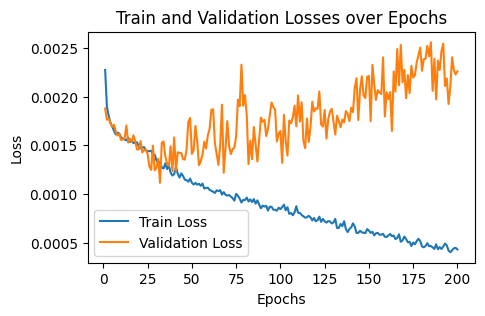

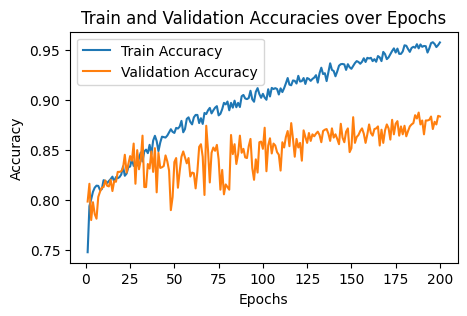

In [32]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [31]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/6000_Transformer_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 22.38it/s]

Best epoch: 188
macro F1 Score: 0.7805922896600928
AUROC: 0.9236788604556604
Accuracy: 0.8797886393659181


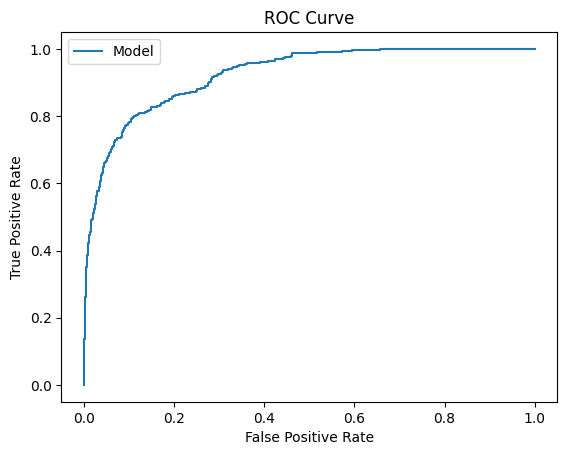

In [34]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)